In [5]:
import numpy as np
import matplotlib.pyplot as plt
import gzip
import os

# -------------------- UTILS -------------------- #
def one_hot(y, num_classes=10):
    return np.eye(num_classes)[y].reshape(-1, num_classes, 1)

def relu(Z):
    return np.maximum(0, Z)

def relu_backward(dA, Z):
    dZ = dA * (Z > 0)
    return dZ

def softmax(Z):
    expZ = np.exp(Z - np.max(Z, axis=0, keepdims=True))
    return expZ / np.sum(expZ, axis=0, keepdims=True)

def compute_cost(Y_hat, Y, parameters, lambd=0.0):
    m = Y.shape[1]
    cost = -np.sum(Y * np.log(Y_hat + 1e-8)) / m
    L2 = sum(np.sum(np.square(W)) for key, W in parameters.items() if 'W' in key)
    return cost + (lambd / (2 * m)) * L2

def initialize_params():
    np.random.seed(1)
    parameters = {
        "W1": np.random.randn(128, 784) * np.sqrt(2. / 784),
        "b1": np.zeros((128, 1)),
        "W2": np.random.randn(10, 128) * np.sqrt(2. / 128),
        "b2": np.zeros((10, 1))
    }
    return parameters

def forward_prop(X, parameters, keep_prob=1.0):
    cache = {}
    Z1 = np.dot(parameters["W1"], X) + parameters["b1"]
    A1 = relu(Z1)

    D1 = np.random.rand(*A1.shape) < keep_prob
    A1 *= D1
    A1 /= keep_prob

    Z2 = np.dot(parameters["W2"], A1) + parameters["b2"]
    A2 = softmax(Z2)
    cache.update({"Z1": Z1, "A1": A1, "D1": D1, "Z2": Z2, "A2": A2})
    return A2, cache

def backward_prop(X, Y, parameters, cache, lambd=0.0, keep_prob=1.0):
    m = X.shape[1]
    grads = {}

    A1, A2 = cache["A1"], cache["A2"]
    D1 = cache["D1"]

    dZ2 = A2 - Y
    grads["dW2"] = np.dot(dZ2, A1.T) / m + (lambd / m) * parameters["W2"]
    grads["db2"] = np.sum(dZ2, axis=1, keepdims=True) / m

    dA1 = np.dot(parameters["W2"].T, dZ2)
    dA1 *= D1
    dA1 /= keep_prob

    dZ1 = relu_backward(dA1, cache["Z1"])
    grads["dW1"] = np.dot(dZ1, X.T) / m + (lambd / m) * parameters["W1"]
    grads["db1"] = np.sum(dZ1, axis=1, keepdims=True) / m
    return grads

# -------------------- OPTIMIZERS -------------------- #
def update_gd(params, grads, lr):
    for key in params:
        params[key] -= lr * grads["d" + key]
    return params

def initialize_momentum(parameters):
    v = {}
    for key in parameters:
        v["d" + key] = np.zeros_like(parameters[key])
    return v

def update_momentum(params, grads, v, beta, lr):
    for key in params:
        v["d" + key] = beta * v["d" + key] + (1 - beta) * grads["d" + key]
        params[key] -= lr * v["d" + key]
    return params, v

def initialize_adam(parameters):
    v = {}
    s = {}
    for key in parameters:
        v["d" + key] = np.zeros_like(parameters[key])
        s["d" + key] = np.zeros_like(parameters[key])
    return v, s

def update_adam(params, grads, v, s, t, lr, beta1, beta2, epsilon):
    v_corrected = {}
    s_corrected = {}
    for key in params:
        v["d" + key] = beta1 * v["d" + key] + (1 - beta1) * grads["d" + key]
        s["d" + key] = beta2 * s["d" + key] + (1 - beta2) * (grads["d" + key] ** 2)

        v_corrected["d" + key] = v["d" + key] / (1 - beta1 ** t)
        s_corrected["d" + key] = s["d" + key] / (1 - beta2 ** t)

        params[key] -= lr * v_corrected["d" + key] / (np.sqrt(s_corrected["d" + key]) + epsilon)
    return params, v, s

# -------------------- TRAINING -------------------- #
def train_model(X, Y, optimizer="adam", epochs=50, lr=0.001, lambd=0.01, keep_prob=1.0):
    parameters = initialize_params()
    t = 0
    if optimizer == "momentum":
        v = initialize_momentum(parameters)
    elif optimizer == "adam":
        v, s = initialize_adam(parameters)

    cost_list = []
    for epoch in range(1, epochs + 1):
        t += 1
        A2, cache = forward_prop(X, parameters, keep_prob)
        cost = compute_cost(A2, Y, parameters, lambd)
        grads = backward_prop(X, Y, parameters, cache, lambd, keep_prob)

        if optimizer == "gd":
            parameters = update_gd(parameters, grads, lr)
        elif optimizer == "momentum":
            parameters, v = update_momentum(parameters, grads, v, 0.9, lr)
        elif optimizer == "adam":
            parameters, v, s = update_adam(parameters, grads, v, s, t, lr, 0.9, 0.999, 1e-8)

        if epoch % 5 == 0:
            cost_list.append(cost)
            print(f"Epoch {epoch}: cost = {cost:.4f}")

    plt.plot(cost_list)
    plt.title(f"{optimizer.upper()} - Cost Over Epochs")
    plt.xlabel("Epochs (per 5)")
    plt.ylabel("Cost")
    plt.grid()
    plt.show()
    return parameters

In [6]:
# -------------------- RUN -------------------- #
def run():
    print("Loading MNIST (first 1000 samples)...")

    X = X_train[:1000].reshape(1000, -1).T  # (784, 1000)
    Y = one_hot(y_train[:1000]).transpose((1, 0, 2)).reshape(10, -1)

    trained_params = train_model(X, Y, optimizer="adam", epochs=50, lr=0.001, lambd=0.01, keep_prob=0.8)

run()

Loading MNIST (first 1000 samples)...


ValueError: shapes (128,784) and (47040,1000) not aligned: 784 (dim 1) != 47040 (dim 0)

In [3]:
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
X_train = x_train.reshape(-1, 784).T.astype(np.float32) / 255.0
X_test  = x_test.reshape(-1, 784).T.astype(np.float32) / 255.0


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 7s 1us/step


Loading MNIST (first 1000 samples)...
Epoch 5: cost = 1.8555
Epoch 10: cost = 1.3372
Epoch 15: cost = 0.9803
Epoch 20: cost = 0.7542
Epoch 25: cost = 0.6219
Epoch 30: cost = 0.5413
Epoch 35: cost = 0.4791
Epoch 40: cost = 0.4421
Epoch 45: cost = 0.4061
Epoch 50: cost = 0.3767
Epoch 55: cost = 0.3618
Epoch 60: cost = 0.3408
Epoch 65: cost = 0.3253
Epoch 70: cost = 0.3086
Epoch 75: cost = 0.3021
Epoch 80: cost = 0.2863
Epoch 85: cost = 0.2760
Epoch 90: cost = 0.2647
Epoch 95: cost = 0.2620
Epoch 100: cost = 0.2515
Epoch 105: cost = 0.2402
Epoch 110: cost = 0.2324
Epoch 115: cost = 0.2224
Epoch 120: cost = 0.2206
Epoch 125: cost = 0.2133
Epoch 130: cost = 0.2075
Epoch 135: cost = 0.1998
Epoch 140: cost = 0.1938
Epoch 145: cost = 0.1893
Epoch 150: cost = 0.1847
Epoch 155: cost = 0.1782
Epoch 160: cost = 0.1712
Epoch 165: cost = 0.1707
Epoch 170: cost = 0.1642
Epoch 175: cost = 0.1603
Epoch 180: cost = 0.1578
Epoch 185: cost = 0.1530
Epoch 190: cost = 0.1494
Epoch 195: cost = 0.1443
Epoch 2

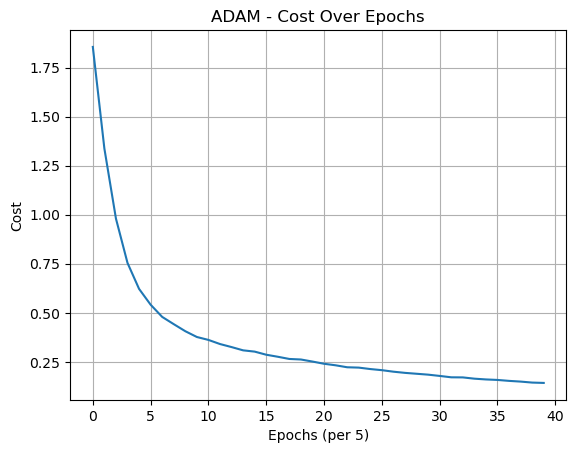

In [12]:
def run():
    print("Loading MNIST (first 1000 samples)...")

    X = X_train[:, :10000] 
    Y = one_hot(y_train[:10000]).transpose((1, 0, 2)).reshape(10, -1)

    trained_params = train_model(X, Y, optimizer="adam", epochs=200, lr=0.001, lambd=0.01, keep_prob=0.8)
    return trained_params
trained_params=run()


In [15]:
def predict(X, parameters, keep_prob=1.0):
    A2, _ = forward_prop(X, parameters, keep_prob)
    return np.argmax(A2, axis=0)



def show_examples(X_orig, y_true, y_pred, correct=True, num=5):
  
    idxs = np.where(y_true == y_pred)[0] if correct else np.where(y_true != y_pred)[0]
    chosen = np.random.choice(idxs, size=min(num, len(idxs)), replace=False)
    
    plt.figure(figsize=(10, 2))
    for i, idx in enumerate(chosen):
        plt.subplot(1, num, i+1)
        plt.imshow(X_orig[idx], cmap='gray')
        plt.title(f"True: {y_true[idx]}\nPred: {y_pred[idx]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()


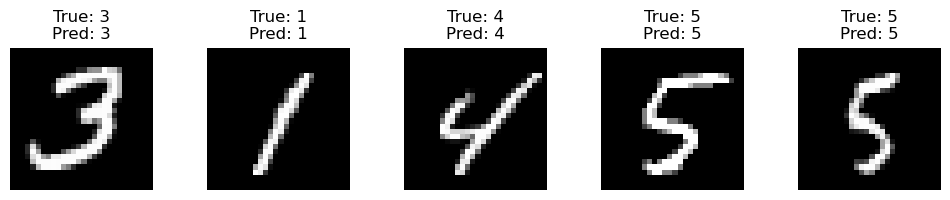

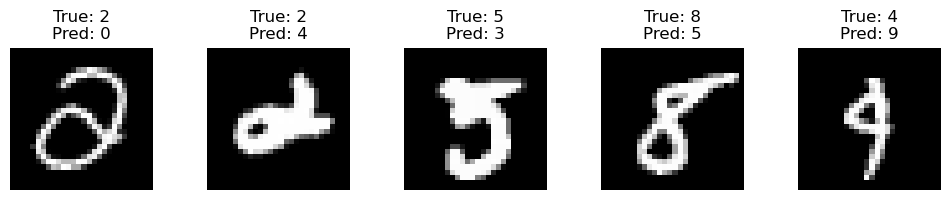

In [16]:
y_pred_test = predict(X_test, trained_params)
show_examples(x_test, y_test, y_pred_test, correct=True, num=5)
show_examples(x_test, y_test, y_pred_test, correct=False, num=5)


In [17]:
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

def plot_per_class_accuracy(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    per_class_acc = cm.diagonal() / cm.sum(axis=1)

    plt.figure(figsize=(8, 5))
    sns.barplot(x=list(range(10)), y=per_class_acc, palette='viridis')
    plt.title("Per-Class Accuracy")
    plt.xlabel("Digit Class")
    plt.ylabel("Accuracy")
    plt.ylim(0, 1.0)
    plt.grid(True)
    plt.show()
    
    print("Classification Report:")
    print(classification_report(y_true, y_pred, digits=4))


In [18]:
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()


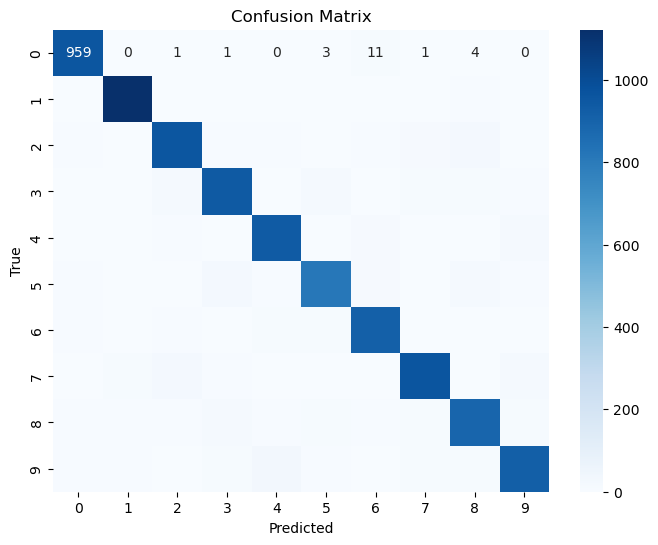

In [19]:
plot_confusion_matrix(y_test, y_pred_test)
